In [35]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
from openparticle import ParticleOperator
import numpy as np
import cirq
import matplotlib.pyplot as plt

import sys, os
sys.path.append(os.path.join(os.path.dirname(os.path.realpath('__file__')), '..'))
from src.lobe.asp import get_target_state, add_prepare_circuit
from src.lobe.system import System
from src.lobe.lcu import LCU
from colors import *
from cirq.contrib.svg import SVGCircuit
from openparticle import generate_matrix
from src.lobe._utils import get_basis_of_full_system
from src.lobe.bosonic import bosonic_mode_block_encoding, bosonic_mode_plus_hc_block_encoding
from src.lobe.index import index_over_terms
from src.lobe.metrics import CircuitMetrics
from src.lobe._utils import get_bosonic_exponents, pretty_print
from functools import partial

In [37]:
def qosc_Hamiltonian(g):
    return ParticleOperator('a0^ a0') + g * (
        ParticleOperator('a0^') + ParticleOperator('a0')
    )**4

In [71]:
def check_unitary(operator, circuit, max_bosonic_occupancy, system, rescaling_factor):
    if len(circuit.all_qubits()) > 18:
        print("Skipped: ", len(circuit.all_qubits()))
    
    full_fock_basis = get_basis_of_full_system(
        system.number_of_modes,
        max_bosonic_occupancy,
        has_fermions=operator.has_fermions,
        has_antifermions=operator.has_antifermions,
        has_bosons=operator.has_bosons,
    )
    expected_unitary = generate_matrix(operator, full_fock_basis)
    
    if len(circuit.all_qubits()) < 12:
        print("Checking Unitary: ", max_bosonic_occupancy)
        rescaled_block = circuit.unitary()[:1 << system.number_of_system_qubits, :1 << system.number_of_system_qubits]*rescaling_factor
        if not np.allclose(rescaled_block, expected_unitary):
            print(circuit)
            print(rescaled_block.real.round(2))
            print(expected_unitary.real.round(2))
            assert False
        print("Passed")
    else:
        print(
            f"Testing singular quantum state for circuit with {len(circuit.all_qubits())} qubits"
        )
        simulator = cirq.Simulator()

        zero_state = np.zeros(
            1 << (
                len(circuit.all_qubits())
                - system.number_of_system_qubits
                - 1
            ), dtype=complex,
        )
        zero_state[0] = 1

        initial_control_state = [1, 0]

        random_system_state = np.zeros(1 << system.number_of_system_qubits)
        while np.isclose(np.linalg.norm(expected_unitary @ random_system_state), 0):
            random_system_state = 1j * np.random.uniform(
                -1, 1, 1 << system.number_of_system_qubits
            )
            random_system_state += np.random.uniform(
                -1, 1, 1 << system.number_of_system_qubits
            )
            random_system_state = random_system_state / np.linalg.norm(
                random_system_state
            )

        initial_state = np.kron(np.kron(zero_state, initial_control_state), random_system_state)

        output_state = simulator.simulate(
            circuit, initial_state=initial_state
        ).final_state_vector
        final_state = output_state[: 1 << system.number_of_system_qubits]

        expected_final_state = expected_unitary @ random_system_state
        expected_final_state = expected_final_state / np.linalg.norm(
            expected_final_state
        )
        normalized_final_state = final_state / np.linalg.norm(final_state)
        if not np.allclose(expected_final_state, normalized_final_state, atol=1e-4):
            print(pretty_print(random_system_state, [system.number_of_system_qubits]))
            print("Failed")
            print(expected_unitary.real.round(2))
            print(pretty_print(expected_final_state, [system.number_of_system_qubits]))
            print(pretty_print(normalized_final_state, [system.number_of_system_qubits]))
            assert False
        print("Passed")

In [72]:
def qosc_lcu_circuit_metrics(max_bosonic_occupancy):
    operator = qosc_Hamiltonian(g = 1).normal_order()
    operator.remove_identity()

    lcu = LCU(operator, max_bosonic_occupancy=max_bosonic_occupancy, zero_threshold=1e-6)
    ctrls = ([cirq.LineQubit(-1000000)], [1])
    circuit = lcu.get_circuit(ctrls=ctrls)
    fake_sys = System(1, max_bosonic_occupancy, 1000 + lcu.number_of_index_qubits, operator.has_fermions, operator.has_antifermions, operator.has_bosons)
    # check_unitary(operator, circuit, max_bosonic_occupancy, fake_sys, lcu.one_norm)

    return lcu.circuit_metrics, lcu.one_norm, len(lcu.index_register)

In [73]:
def qosc_lobe_circuit_metrics(max_bosonic_occupancy):
    operator = qosc_Hamiltonian(1).normal_order()
    operator.remove_identity()
    terms = operator.group()
    
    number_of_block_encoding_anillae = 2
    index_register = [cirq.LineQubit(-i - 2) for i in range(int(np.ceil(np.log2(len(terms)))))]
    block_encoding_ancillae = [cirq.LineQubit(-100 - i - len(index_register)) for i in range(number_of_block_encoding_anillae)]
    ctrls = ([cirq.LineQubit(0)], [1])
    clean_ancillae = [cirq.LineQubit(i + 100) for i in range(100)]
    system = System(1, max_bosonic_occupancy, 1000, False, False, True)

    block_encoding_functions = []
    rescaling_factors = []
    for term in terms:
        plus_hc = False
        if len(term) == 2:
            plus_hc = True
            term = term.to_list()[0]
        active_modes, exponents_list = get_bosonic_exponents(term, 1)
        exponents = exponents_list[0]

        if not plus_hc:
            block_encoding_functions.append(partial(
                bosonic_mode_block_encoding,
                system=system,
                block_encoding_ancilla=block_encoding_ancillae[1],
                active_index=active_modes[0],
                exponents=exponents,
                clean_ancillae=clean_ancillae[1:]
            ))
            rescaling_factors.append(np.sqrt(max_bosonic_occupancy)**(sum(exponents)))
        else:
            block_encoding_functions.append(partial(
                bosonic_mode_plus_hc_block_encoding,
                system=system,
                block_encoding_ancillae=block_encoding_ancillae,
                active_index=active_modes[0],
                exponents=exponents,
                clean_ancillae=clean_ancillae[1:]
            ))
            rescaling_factors.append(2*np.sqrt(max_bosonic_occupancy)**(sum(exponents)))



    rescaled_coefficients = []
    for term, rescaling_factor in zip(terms, rescaling_factors):
        rescaled_coefficients.append(term.coeffs[0] * rescaling_factor / max(rescaling_factors))

    target_state = get_target_state(rescaled_coefficients)
    gates = []
    metrics = CircuitMetrics()

    gates.append(cirq.X.on(ctrls[0][0]))

    _gates, _metrics = add_prepare_circuit(index_register, target_state, clean_ancillae=clean_ancillae)
    gates += _gates
    metrics += _metrics

    _gates, _metrics = index_over_terms(index_register, block_encoding_functions, clean_ancillae, ctrls=ctrls)
    gates += _gates
    metrics += _metrics

    _gates, _metrics = add_prepare_circuit(index_register, target_state, dagger=True, clean_ancillae=clean_ancillae)
    gates += _gates
    metrics += _metrics

    gates.append(cirq.X.on(ctrls[0][0]))

    overall_rescaling_factor = sum([term.coeffs[0]*rescaling_factor for term, rescaling_factor in zip(terms, rescaling_factors)])
    circuit = cirq.Circuit(gates)
    check_unitary(operator, circuit, max_bosonic_occupancy, system, overall_rescaling_factor)

    return  metrics, overall_rescaling_factor, len(index_register) + number_of_block_encoding_anillae

In [75]:
omegas = [1, 3, 7, 15, 31]
print("LCU")
LCU_DATA = [qosc_lcu_circuit_metrics(omega) for omega in omegas]
print("LOBE")
LOBE_DATA = [qosc_lobe_circuit_metrics(omega) for omega in omegas]

system_qubits = [System(1, omega, 1000, False, False, True).number_of_system_qubits for omega in omegas]

LCU
LOBE
Checking Unitary:  1
Passed
Testing singular quantum state for circuit with 12 qubits
Passed
Testing singular quantum state for circuit with 14 qubits
Passed
Testing singular quantum state for circuit with 16 qubits
Passed
Testing singular quantum state for circuit with 18 qubits
Passed


In [76]:
def matrix_element(k, l, g):
    return (k + 3 * g * (2 * k ** 2 + 2 * k + 1)) * delta(k, l) +\
            g * (4 * l + 6) * np.sqrt((l + 1) * (l + 2)) * delta(k, l + 2) +\
            g * (4 * k + 6) * np.sqrt((k + 1) * (k + 2)) * delta(k + 2, l) +\
            g * np.sqrt((l + 1) * (l + 2) * (l + 3) * (l + 4)) * delta(k, l + 4) +\
            g * np.sqrt((k + 1) * (k + 2) * (k + 3) * (k + 4)) * delta(k + 4, l) 

def delta(k, l):
    if k == l: return 1 
    return 0


def _get_qosc_hamiltonian_norm(max_bosonic_occupancy, g=1):
    H_from_matrix_elements = np.zeros((max_bosonic_occupancy + 1, max_bosonic_occupancy + 1))

    for i in range(max_bosonic_occupancy + 1):
        for j in range(max_bosonic_occupancy + 1):
            H_from_matrix_elements[i][j] = matrix_element(i, j, g)

    vals = np.linalg.eigvalsh(H_from_matrix_elements)
    return max(np.abs(vals))

In [77]:
operator = qosc_Hamiltonian(1).normal_order()
operator.remove_identity()
operator_norms = []
for omega in omegas:
    operator_norms.append(_get_qosc_hamiltonian_norm(omega))
    print(omega, operator_norms[-1])

1 16.0
3 86.50949253027682
7 465.3766497208944
15 2372.168169309277
31 11342.80533747993


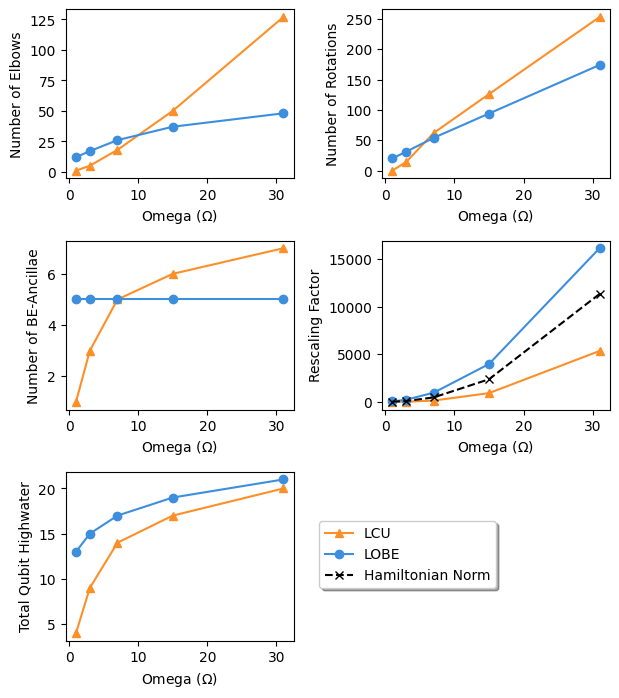

In [78]:
fig, axes = plt.subplots(3, 2, figsize=(16 / 2.54, 18 / 2.54))

axes[0][0].plot(omegas, [LCU_DATA[i][0].number_of_elbows for i in range(len(omegas))], color=ORANGE, marker='^', alpha = 1)
axes[0][0].plot(omegas, [LOBE_DATA[i][0].number_of_elbows for i in range(len(omegas))], color=BLUE, marker='o', alpha = 1)
axes[0][0].set_ylabel("Number of Elbows")
axes[0][0].set_xlabel("Omega ($\Omega$)")

axes[0][1].plot(omegas, [LCU_DATA[i][0].number_of_rotations for i in range(len(omegas))], color=ORANGE, marker='^', alpha = 1)
axes[0][1].plot(omegas, [LOBE_DATA[i][0].number_of_rotations for i in range(len(omegas))], color=BLUE, marker='o', alpha = 1)
axes[0][1].set_ylabel("Number of Rotations")
axes[0][1].set_xlabel("Omega ($\Omega$)")

axes[1][0].plot(omegas, [LCU_DATA[i][2] for i in range(len(omegas))], color=ORANGE, marker='^', alpha = 1)
axes[1][0].plot(omegas, [LOBE_DATA[i][2] for i in range(len(omegas))], color=BLUE, marker='o', alpha = 1)
axes[1][0].set_ylabel("Number of BE-Ancillae")
axes[1][0].set_xlabel("Omega ($\Omega$)")

axes[1][1].plot(omegas, [LCU_DATA[i][1] for i in range(len(omegas))], color=ORANGE, marker='^', alpha = 1)
axes[1][1].plot(omegas, [LOBE_DATA[i][1] for i in range(len(omegas))], color=BLUE, marker='o', alpha = 1)
axes[1][1].plot(omegas, [operator_norms[i] for i in range(len(omegas))], color="black", marker='x', ls='--', alpha = 1)
axes[1][1].set_ylabel("Rescaling Factor")
axes[1][1].set_xlabel("Omega ($\Omega$)")

axes[2][0].plot(omegas, [LCU_DATA[i][0].ancillae_highwater() + LCU_DATA[i][2] + system_qubits[i] + 1 for i in range(len(omegas))], color=ORANGE, marker='^', alpha = 1, label="LCU")
axes[2][0].plot(omegas, [LOBE_DATA[i][0].ancillae_highwater() + LOBE_DATA[i][2] + system_qubits[i] + 1 for i in range(len(omegas))], color=BLUE, marker='o', alpha = 1, label="LOBE")
axes[2][0].plot([], [], color="black", marker='x', ls='--', alpha = 1, label="Hamiltonian Norm")
axes[2][0].set_ylabel("Total Qubit Highwater")
axes[2][0].set_xlabel("Omega ($\Omega$)")

fig.delaxes(axes[2][1])
plt.tight_layout()
axes[2][0].legend(loc='upper center', bbox_to_anchor=(1.5, 0.75),
          fancybox=True, shadow=True, ncol=1)
plt.savefig("../manuscript/figures/quartic_oscillator.pdf", dpi=300)